<a href="https://colab.research.google.com/github/njmarko/gat-or/blob/master/gat_or.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GATor

GATor is a Graph Attention Network for object detection with relational reasoning.

### Installing dependencies and downloading dataset

In [1]:
!pip uninstall opencv-python-headless
!pip install opencv-python-headless==4.1.2.30
!pip install fiftyone

Found existing installation: opencv-python-headless 4.1.2.30
Uninstalling opencv-python-headless-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.1.2.30.dist-info/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libQtCore-bbdab771.so.4.8.7
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libQtGui-903938cd.so.4.8.7
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libQtTest-1183da5d.so.4.8.7
Proceed (y/n)? y
  Successfully uninstalled opencv-python-headless-4.1.2.30
  Using cached opencv_python_headless-4.1.2.30-cp37-cp37m-manylinux1_x86_64.whl (21.8 MB)


In [2]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

cd ..
rm -r vision

Cloning into 'vision'...
remote: Enumerating objects: 78901, done.
remote: Counting objects: 100% (14036/14036), done.
remote: Compressing objects: 100% (1239/1239), done.
remote: Total 78901 (delta 12899), reused 13757 (delta 12721), pack-reused 64865
Receiving objects: 100% (78901/78901), 154.22 MiB | 13.48 MiB/s, done.
Resolving deltas: 100% (65976/65976), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [3]:
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.utils.coco as fouc
from fiftyone import ViewField as VF
import numpy as np
from itertools import product
from tqdm import tqdm
import seaborn as sns
import networkx as nx
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.transforms import functional as F
from transforms import Compose, ToTensor
from PIL import Image
import matplotlib.pylab as plt
import matplotlib.patches as patches
from matplotlib.pyplot import figure

from engine import train_one_epoch, evaluate
import utils

In [4]:
dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="train",
    max_samples=600
)
dataset.persistent = True

session = fo.launch_app(dataset)

Found annotations at '/root/fiftyone/coco-2017/raw/instances_train2017.json'
Sufficient images already downloaded
Existing download of split 'train' is sufficient
Loading existing dataset 'coco-2017-train-600'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


### Visualizing co-occurrence matrix

In [5]:
class_names = ['background','person','bicycle','car','motorcycle','airplane','bus','train','truck','boat','traffic light','fire hydrant','street sign','stop sign','parking meter','bench','bird','cat','dog','horse',
'sheep','cow','elephant','bear','zebra','giraffe','hat','backpack','umbrella','shoe','eye glasses','handbag','tie','suitcase','frisbee','skis','snowboard','sports ball','kite','baseball bat','baseball glove','skateboard',
'surfboard','tennis racket','bottle','plate','wine glass','cup','fork','knife','spoon','bowl','banana','apple','sandwich','orange','broccoli','carrot','hot dog','pizza','donut','cake','chair','couch','potted plant','bed',
'mirror','dining table','window','desk','toilet','door','tv','laptop','mouse','remote','keyboard','cell phone','microwave','oven','toaster','sink','refrigerator','blender','book','clock','vase','scissors','teddy bear',
'hair drier','toothbrush','hair brush'
]

class_name_to_idx = {elem:idx for idx, elem in enumerate(class_names)}
n_classes = len(class_names)
co_occurrence_matrix = np.zeros((n_classes, n_classes))

with fo.ProgressBar() as pb:
  for sample in pb(dataset):
    detections = sample.ground_truth.detections
    for attention_pair in product(detections, detections):
      i = class_name_to_idx[attention_pair[0].label]
      j = class_name_to_idx[attention_pair[1].label]
      co_occurrence_matrix[i][j] += 1
      co_occurrence_matrix[j][i] += 1

 100% |█████████████████| 600/600 [5.0s elapsed, 0s remaining, 115.1 samples/s]      


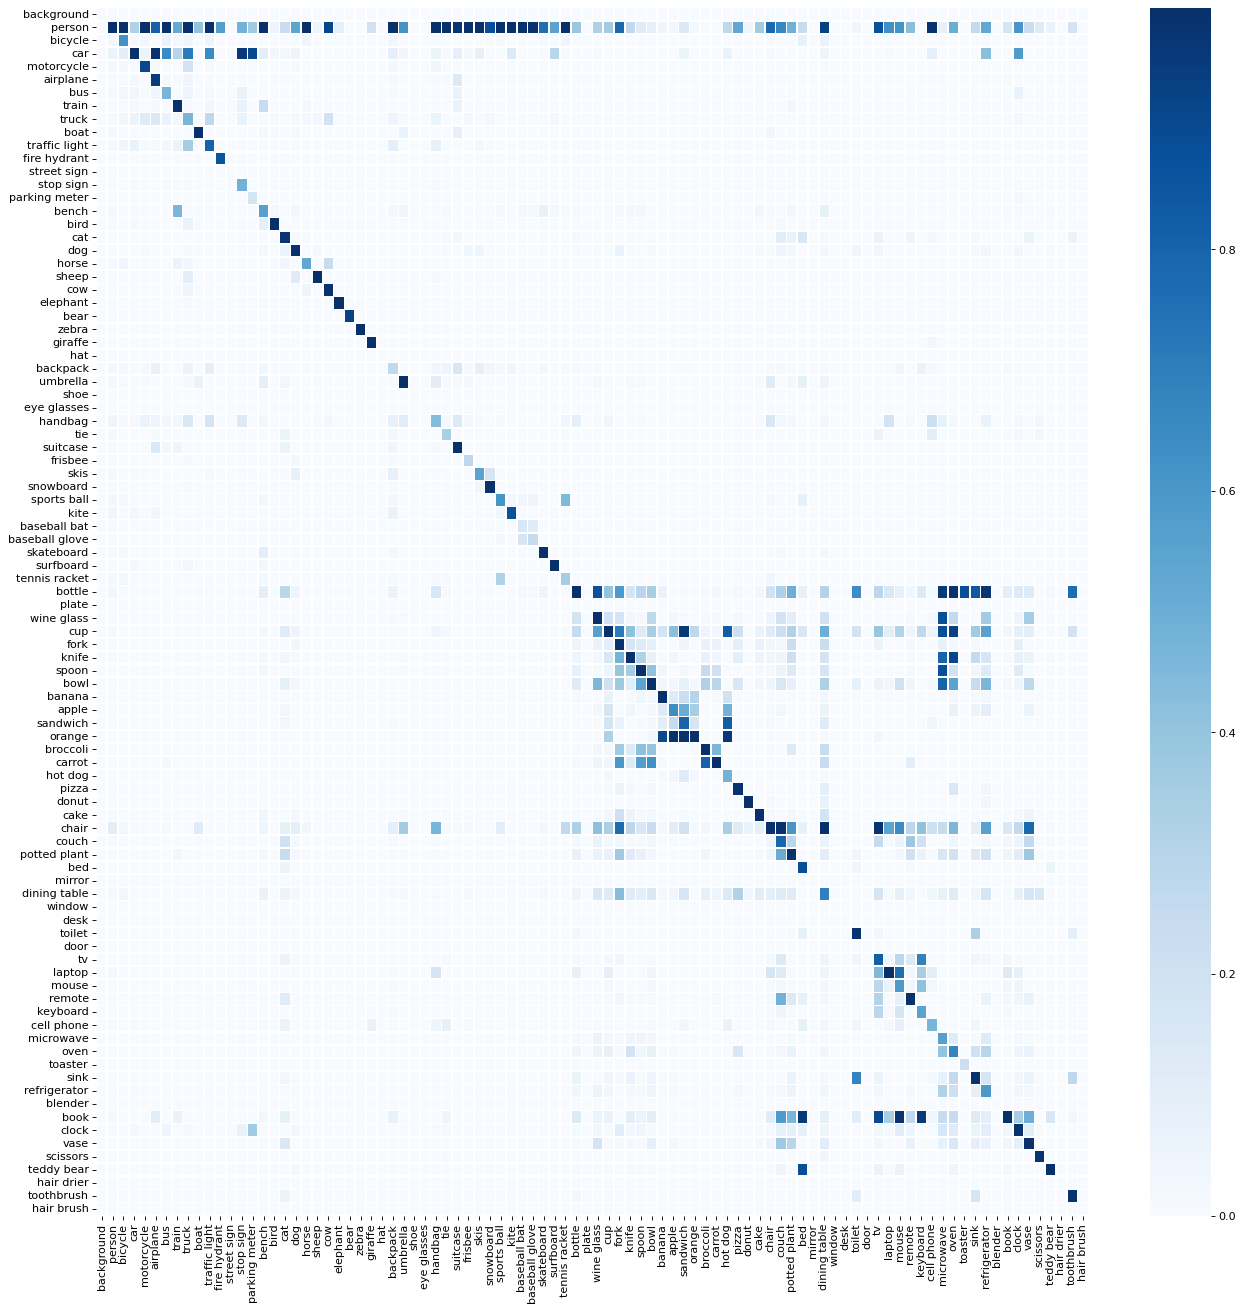

In [6]:
normalized_matrix = co_occurrence_matrix / np.amax(co_occurrence_matrix + 1.0, axis=1)

figure(figsize=(20, 20), dpi=80)
ax = sns.heatmap(normalized_matrix, linewidth=0.5, xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.show()

### Defining PyTorch dataset

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [10]:
class Resize(object):
  def __init__(self, size, interpolation=F.InterpolationMode.BILINEAR, max_size=None, antialias=None):
    self.size = size
    self.max_size = max_size
    self.interpolation = interpolation
    self.antialias = antialias

  def __call__(self, image, target):
    assert torch.is_tensor(image), "Image is expected to be of type torch.tensor"
    original_shape = image.shape
    image = F.resize(image, self.size, self.interpolation, self.max_size, self.antialias)
    transformed_shape = image.shape
    x_scale = transformed_shape[2] / original_shape[2]
    y_scale = transformed_shape[1] / original_shape[1]
    scale_tensor = torch.tensor([x_scale, y_scale]).repeat(target['boxes'].shape[0], 2)
    target['boxes'] = torch.mul(target['boxes'], scale_tensor)
    return image, target

In [11]:
class TorchCocoDataset(torch.utils.data.Dataset):
  def __init__(self, fiftyone_dataset, transforms=None, gt_field="ground_truth"):
    self.samples = fiftyone_dataset
    self.transforms = transforms
    self.gt_field = gt_field
    self.img_paths = self.samples.values("filepath")
    self.classes = class_names
    self.labels_map_rev = class_name_to_idx

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    sample = self.samples[img_path]
    metadata = sample.metadata
    img = Image.open(img_path).convert("RGB")

    boxes = []
    labels = []
    area = []
    iscrowd = []
    detections = sample[self.gt_field].detections

    for det in detections:
      category_id = self.labels_map_rev[det.label]
      coco_obj = fouc.COCOObject.from_label(
          det, metadata, category_id=category_id,
      )
      x, y, w, h = coco_obj.bbox
      boxes.append([x, y, x + w, y + h])
      labels.append(coco_obj.category_id)
      area.append(coco_obj.area)
      iscrowd.append(coco_obj.iscrowd)

    target = {}
    target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
    target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
    target["image_id"] = torch.as_tensor([idx])
    target["area"] = torch.as_tensor(area, dtype=torch.float32)
    target["iscrowd"] = torch.as_tensor(iscrowd, dtype=torch.int64)

    if self.transforms:
        img, target = self.transforms(img, target)

    return img, target

  def __len__(self):
    return len(self.img_paths)

  def get_classes(self):
    return self.classes

In [12]:
has_bounding_box_view = dataset.filter_labels(
        "ground_truth",
        VF("label").is_in(class_names)
)

train_transforms = Compose([ToTensor(), Resize(size=(256, 256))])
test_transforms = Compose([ToTensor()])

train_view = has_bounding_box_view.take(500, seed=51)
test_view = has_bounding_box_view.exclude([s.id for s in train_view])

print(f"Number of training samples: {len(train_view)}")
print(f"Number of test samples: {len(test_view)}")

torch_dataset_train = TorchCocoDataset(train_view, train_transforms)
torch_dataset_test = TorchCocoDataset(test_view, test_transforms)

Number of training samples: 500
Number of test samples: 95


In [13]:
def draw_image_with_bounding_boxes(image, target):
  fig, ax = plt.subplots()
  ax.imshow(image.permute(1, 2, 0))
  for box in target['boxes']:
    x = box[0]
    y = box[1]
    h = box[2] - x
    w = box[3] - y
    rect = patches.Rectangle((x, y), h, w, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
  plt.show()

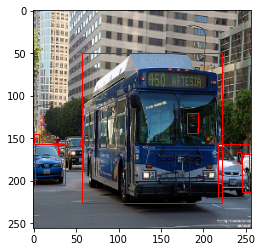

In [14]:
draw_image_with_bounding_boxes(*torch_dataset_train[0])

### Defining the model

In [15]:
cached = {}
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [16]:
class GATModule(nn.Module):
  def __init__(self, box_head):
    super(GATModule, self).__init__()
    self.box_head = box_head
  
  def forward(self, x):
    # print("DOING FORWARD")
    # print(f"Cached boxes shape: {cached['boxes'].shape}")
    # print(x)
    # print(x.shape)
    # print("================================")
    # transform to graph -> bbox to nodes
    # process graph -> community detection
    # process with out GAT model
    x = self.box_head(x)
    # print(x)
    # print(x.shape)
    # print("==================================")
    return x

In [17]:
class RPNWrapper(nn.Module):
  def __init__(self, rpn):
    super(RPNWrapper, self).__init__()
    self.rpn = rpn
  
  def forward(self, images, features, targets=None):
    x = self.rpn(images, features, targets)
    # print("~~~~~~~~~~~~~~~~~~~~~~")
    # print(x[0][0].shape)
    # print(x)
    cached['boxes'] = x[0][0]
    # print("~~~~~~~~~~~~~~~~~~~~~~")
    return x

In [18]:
gat = GATModule(model.roi_heads.box_head)
model.rpn = RPNWrapper(model.rpn)
model.roi_heads.box_head = gat
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### Definint PyTorch dataloaders

In [19]:
def collate_fn(batch):
  return tuple(zip(*batch))

In [20]:
data_loader_train = DataLoader(torch_dataset_train, batch_size=4, shuffle=True, collate_fn=collate_fn, pin_memory=True)
data_loader_test = DataLoader(torch_dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

### Training

In [21]:
def train(model, train_loader, test_loader, n_epochs):
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  model.train()
  for param in model.parameters():
    param.requires_grad = False
  for param in model.roi_heads.parameters():
    param.requires_grad = True
  model.to(device)
  params = [p for p in model.parameters() if p.requires_grad]
  optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)
  det_id = 0

  for epoch in range(n_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, test_loader, device=device)

In [22]:
train(model, data_loader_train, data_loader_test, n_epochs=2)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [  0/125]  eta: 0:02:55  lr: 0.000045  loss: 1.3301 (1.3301)  loss_classifier: 0.3302 (0.3302)  loss_box_reg: 0.3776 (0.3776)  loss_objectness: 0.4527 (0.4527)  loss_rpn_box_reg: 0.1696 (0.1696)  time: 1.4050  data: 0.1605  max mem: 1169
Epoch: [0]  [ 10/125]  eta: 0:02:04  lr: 0.000448  loss: 0.7395 (0.8487)  loss_classifier: 0.2649 (0.2643)  loss_box_reg: 0.2950 (0.2752)  loss_objectness: 0.1217 (0.2015)  loss_rpn_box_reg: 0.0858 (0.1077)  time: 1.0822  data: 0.1300  max mem: 1277
Epoch: [0]  [ 20/125]  eta: 0:01:52  lr: 0.000851  loss: 0.6888 (0.7700)  loss_classifier: 0.2557 (0.2615)  loss_box_reg: 0.2820 (0.2855)  loss_objectness: 0.0931 (0.1403)  loss_rpn_box_reg: 0.0522 (0.0827)  time: 1.0500  data: 0.1277  max mem: 1277
Epoch: [0]  [ 30/125]  eta: 0:01:41  lr: 0.001254  loss: 0.6277 (0.7430)  loss_classifier: 0.2297 (0.2598)  loss_box_reg: 0.2513 (0.2770)  loss_objectness: 0.0485 (0.1285)  loss_rpn_box_reg: 0.0522 (0.0778)  time: 1.0551  data: 0.1275  max mem: 1277


### Evaluation

In [23]:
def convert_torch_predictions(preds, det_id, s_id, w, h, classes):
  # Convert the outputs of the torch model into a FiftyOne Detections object
  dets = []
  for bbox, label, score in zip(preds["boxes"].cpu().detach().numpy(), preds["labels"].cpu().detach().numpy(), preds["scores"].cpu().detach().numpy()):
    # Parse prediction into FiftyOne Detection object
    x0,y0,x1,y1 = bbox
    coco_obj = fouc.COCOObject(det_id, s_id, int(label), [x0, y0, x1-x0, y1-y0])
    det = coco_obj.to_detection((w,h), classes)
    det["confidence"] = float(score)
    dets.append(det)
    det_id += 1
        
  detections = fo.Detections(detections=dets)
      
  return detections, det_id

In [24]:
def add_detections(model, torch_dataset, view, field_name="predictions"):
  # Run inference on a dataset and add results to FiftyOne
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

  model.eval()
  model.to(device)
  image_paths = torch_dataset.img_paths
  classes = torch_dataset.classes
  det_id = 0
  
  print("Adding detections to FiftyOne view...")
  with fo.ProgressBar() as pb:
    for img, targets in pb(torch_dataset):
      # Get FiftyOne sample indexed by unique image filepath
      img_id = int(targets["image_id"][0])
      img_path = image_paths[img_id]
      sample = view[img_path]
      s_id = sample.id
      w = sample.metadata["width"]
      h = sample.metadata["height"]
      
      # Inference
      preds = model(img.unsqueeze(0).to(device))[0]
      
      detections, det_id = convert_torch_predictions(
          preds, 
          det_id, 
          s_id, 
          w, 
          h, 
          classes,
      )
      
      sample[field_name] = detections
      sample.save()

In [25]:
add_detections(model, torch_dataset_test, test_view)

results = fo.evaluate_detections(test_view, "predictions", eval_key="eval", compute_mAP=True) 

Adding detections to FiftyOne view...
 100% |███████████████████| 95/95 [41.0s elapsed, 0s remaining, 2.4 samples/s]      
Evaluating detections...
 100% |███████████████████| 95/95 [7.4s elapsed, 0s remaining, 13.9 samples/s]      
Performing IoU sweep...
 100% |███████████████████| 95/95 [10.5s elapsed, 0s remaining, 10.5 samples/s]     


In [26]:
print(results.mAP())

0.5464527711403965


In [27]:
results.plot_confusion_matrix()

/usr/local/lib/python3.7/dist-packages/fiftyone/core/plots/plotly.py:1441: UserWarning:

Interactive plots are currently only supported in Jupyter notebooks. Support outside of notebooks and in Google Colab will be included in an upcoming release. In the meantime, you can still use this plot, but note that (i) selecting data will not trigger callbacks, and (ii) you must manually call `plot.show()` to launch a new plot that reflects the current state of an attached session.

See https://voxel51.com/docs/fiftyone/user_guide/plots.html#working-in-notebooks for more information.



In [28]:
results.plot_pr_curves()

In [29]:
session.view = test_view